IA & Data science (LU3IN0226) -- 2021-2022
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Olivier Schwander.*

# TD-TME08: méthodes d'ensembles

L'objectif de ce notebook est d'implémenter des méthodes d'ensembles et de les évaluer. Dans un premier temps, on se focalisera sur l'algorithme de bagging appliqué aux arbres de décision, puis on passera au random forests.

Dans un premier temps, on ne considére que le cas où les attributs sont tous numériques.

<font color="RED" size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Samy NEHLIL 21113646

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-08</tt> et rajouter à la suite de <tt>tme-08</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-08-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

In [1]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

## Préparation : retour sur les arbres de décision

### Création d'un dataset pour tester les fonctions

Taille du dataset généré : (100, 2) exemples


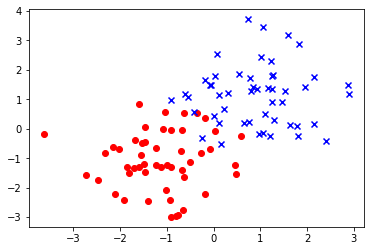

In [2]:
# On initialise la graine
np.random.seed(42)   

d_desc, d_label = ut.genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                             np.array([-1,-1]),np.array([[1,0],[0,1]]), 50)

print("Taille du dataset généré :", np.shape(d_desc), "exemples")

# Affichage :
ut.plot2DSet(d_desc,d_label)

### Frontière de séparation des classes 

Après avoir recopié vos fonctions de construction des arbres numériques du TME 7, afficher la frontière de séparation des classes et l'arbre obtenu pour les données générées.

Accuracy (train):  1.0


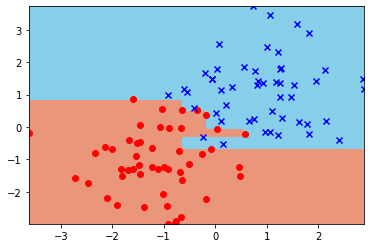

In [3]:
# De même, les classes de Classifiers sont utilisables en mettant classif. devant leur nom:
# Création d'un perceptron
arbre_1 = cl.ClassifierArbreNumerique(2, 0.0)

# Construction de l'arbre de décision à partir du dataset généré plus haut
arbre_1.train(d_desc,d_label)
print("Accuracy (train): ", arbre_1.accuracy(d_desc,d_label))

# Affichage de la frontière de séparation des classes
ut.plot_frontiere(d_desc,d_label,arbre_1,step=100)
ut.plot2DSet(d_desc,d_label)

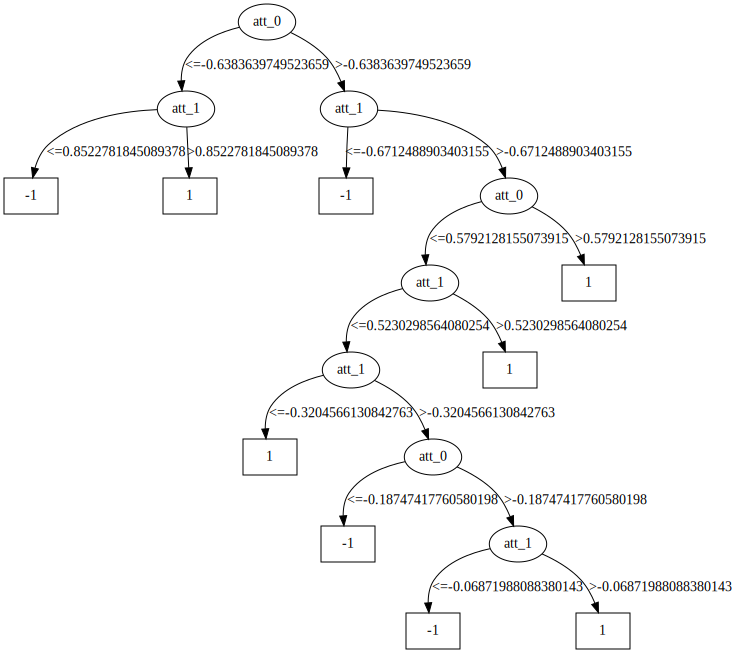

In [4]:
import graphviz as gv

# Construction de la représentation graphique (affichage)
graphe_arbre_1 = gv.Digraph(format='png')
arbre_1.affiche(graphe_arbre_1)

# Affichage du graphe obtenu:
graphe_arbre_1

<font color="RED" size="+1"><b>[Q]</b></font> Sur une feuille de papier, représenter la frontière de séparation des classes en la dessinant à la main et en utilisant l'arbre ci-dessus.

Même chose mais en utilisant un seuil d'entropie lors de la construction, ici égal à $0.3$ 


Accuracy (train):  0.95


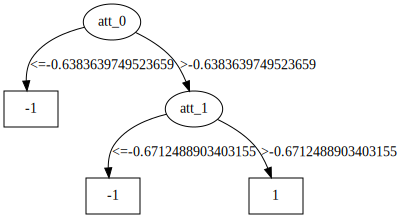

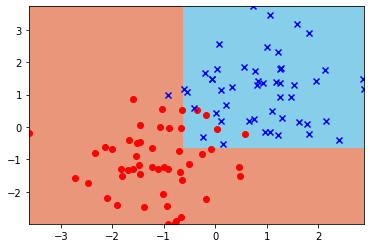

In [35]:
# De même, les classes de Classifiers sont utilisables en mettant classif. devant leur nom:
# Création d'un perceptron
arbre_2 = cl.ClassifierArbreNumerique(2, 0.30)

# Construction de l'arbre de décision à partir du dataset généré plus haut
arbre_2.train(d_desc,d_label)
print("Accuracy (train): ", arbre_2.accuracy(d_desc,d_label))

# Affichage de la frontière de séparation des classes
ut.plot_frontiere(d_desc,d_label,arbre_2,step=100)
ut.plot2DSet(d_desc,d_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_2 = gv.Digraph(format='png')
arbre_2.affiche(graphe_arbre_2)

# Affichage du graphe obtenu:
graphe_arbre_2

## Bagging d'arbres de décision

### Tirage aléatoire d'exemples

Le bootstrap s'effectue en tirant aléatoirement un échantillon de $m$ exemples à partir de la base d'apprentissage $X$. Cet échantillon sert ensuite à construire un classifieur.

Dans l'algorithme du bagging, ce processus est répété $B$ fois.

Afin de ne pas alourdir la place mémoire nécessaire pour réaliser un tel tirage, on ne travaille que sur les indices des exemples dans la base. Un **échantillon de $X$ est donc un vecteur d'entiers** qui représentent les indices des exemples choisis.


### Tirages aléatoires

Consulter la librairie Python random qui propose différentes fonctions utiles pour implémenter le tirage aléatoire du bootstrap.

Par exemple, la fonction <code>sample()</code> de la librairie <code>random</code> rend une sélection aléatoire dans une population donnée en réalisant un tirage sans remise.

Pour tester, exécuter plusieurs fois les instructions de la boîte suivante :

In [36]:
import random

# ATTENTION : on utilise ici les fonctions de la librairie random pas numpy !
# Donc, on ne préfixe pas les fonction par np.
random.seed(42)   # on prend 42 comme graine

L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
EchL_1 = random.sample(L,6)               # tirage de 6 éléments de L
print("Echantillon 1: ",EchL_1)
EchL_2 = random.sample(L,6)               # un autre tirage de 6 éléments de L
print("Echantillon 2: ",EchL_2)


La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Echantillon 1:  [10, 1, 0, 4, 9, 6]
Echantillon 2:  [2, 1, 8, 9, 4, 3]


La fonction <code>choice()</code> permet de choisir aléatoirement un élément dans une liste:

In [37]:
random.seed(42)   # on prend 42 comme graine

L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
elt = random.choice(L)                  # choix d'un élémént
print("Element choisi: ",elt)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Element choisi:  10


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>tirage()</code> qui étant donné un vecteur d'entiers <i>VX</i> qui représente l'ensemble des indices des exemples d'une base d'apprentissage <i>X</i>, un entier $m$, et un booléen $r$, rend un vecteur de $m$ indices choisis aléatoirement dans <i>VX</i>. Si le booléen $r$ est vrai, le tirage s'effectue *avec remise*, sinon il s'effectue *sans remise*.

In [38]:
import random
def tirage(VX, m, r = False):
    """
    Arguments: 
        VX : ensemble des indices des exemples de la BA X
        m  : taille du vecteur d'indices à rendre
        r  : booleen indiquant si il y a remise ou pas dans le tirage
    """
    return [random.choice(VX) for i in range(m)] if r else random.sample(VX,m)

Exemples :

In [39]:
random.seed(42)   # on prend 42 comme graine
L= [i for i in range(0,10)]    # construction de la liste des entiers de 0 à 100
tirage(L,8,True)               # tirage avec remise

[1, 0, 4, 3, 3, 2, 1, 8]

In [40]:
tirage(L,8,False)               # tirage sans remise

[1, 6, 0, 7, 8, 9, 4, 2]

In [41]:
# Pour rappel:
# 10 premières lignes de d_desc:
d_desc[0:10,:]

array([[-0.50328585, -1.1382643 ],
       [-0.35231146,  0.52302986],
       [-1.23415337, -1.23413696],
       [ 0.57921282, -0.23256527],
       [-1.46947439, -0.45743996],
       [-1.46341769, -1.46572975],
       [-0.75803773, -2.91328024],
       [-2.72491783, -1.56228753],
       [-2.01283112, -0.68575267],
       [-1.90802408, -2.4123037 ]])

In [42]:
# Choix de lignes quelconques de d_desc
L=[0,5,1,0,0]
d_desc[L,:]

array([[-0.50328585, -1.1382643 ],
       [-1.46341769, -1.46572975],
       [-0.35231146,  0.52302986],
       [-0.50328585, -1.1382643 ],
       [-0.50328585, -1.1382643 ]])

In [43]:
# et les labels
d_label[L]

array([-1, -1, -1, -1, -1])

In [44]:
# Choix de lignes quelconques de d_desc
L=[0,99,12,80]
d_desc[L,:]

array([[-0.50328585, -1.1382643 ],
       [ 1.05820872, -0.1429703 ],
       [-1.54438272, -0.88907741],
       [ 0.02531833,  1.7870846 ]])

In [45]:
d_label[L]

array([-1,  1, -1,  1])

Dans ce qui suit, pour faciliter les énoncés, on appelle <code>LabeledSet</code> un couple de 2 np.arrays $X$ pour les descriptions des exemples et $Y$ pour les labels correspondant à chaque exemple.

Par exemple, le <code>LabeledSet</code> pour les données générées précédemment est <code>(d_desc,d_label)</code>.

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction précédente, écrire la fonction <code>echantillonLS()</code> qui, étant donné un <code>LabeledSet</code> $LS$, un nombre entier $m$, et un booléen $r$ (avec ou sans remise) rend le <code>LabeledSet</code> échantillon de $LS$ de taille $m$. 

*Remarque*: on peut faire l'hypothèse que $m$ est inférieur ou égal au nombre de lignes de $LS$. 


In [46]:
def echantillonLS(LS, m, r):
    """
    Arguments: 
        LS : couple de 2 np.arrays (X,Y)
        m  : taille du vecteur d'indices à rendre
        r  : booleen indiquant si il y a remise ou pas dans le tirage
    """
    X,Y = LS[0], LS[1]
    VX = tirage([i for i in range(len(X))], m, r)
    return X[VX], Y[VX]

In [47]:
echantillonLS((d_desc,d_label),10,True)

(array([[ 1.29307247,  0.28564858],
        [ 0.57921282, -0.23256527],
        [-0.60748323,  1.18463386],
        [-0.67591603, -1.38508228],
        [-0.0708925 ,  1.48247242],
        [ 1.82206016,  2.89679298],
        [ 0.73534317,  3.72016917],
        [ 1.81351722, -0.23086432],
        [ 2.8861859 ,  1.17457781],
        [-1.83921752, -1.30921238]]),
 array([ 1, -1,  1, -1,  1,  1,  1,  1,  1, -1]))

<font color="RED" size="+1">**[Q]**</font> Ecrire la classe <code>ClassifierBaggingTree</code>, dérivée de la classe <code>Classifier</code>, qui permet d'implémenter un bagging d'arbres de décision (numériques). Les spécifications de cette classe sont :
- la création de l'ensemble nécessite les paramètres suivants : 
    - le nombre $B$ d'arbres à construire, 
    - le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon, 
    - un booléen qui précise si un échantillon est tiré avec ou sans remise
    - et la valeur de seuil d'entropie pour arrêter la construction de chaque arbre, 
- l'apprentissage (méthode <code>train()</code>) construit autant d'arbres que précisé à la création. Chaque arbre est construit à partir d'un échantillon de la base d'apprentissage (donnée sous forme d'un <code>LabeledSet</code>) donnée en argument. Les arbres construits sont stockés dans un ensemble Python.
- la prédiction (méthode <code>predict()</code>) classe un exemple par vote de tous les arbres de la forêt. Si la somme des votes est positive ou nulle, la classe rendue est +1, sinon, la classe rendue est -1.


In [74]:
class ClassifierBaggingTree(cl.Classifier):
    def __init__(self, B, perc, seuil, r):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        self.B = B
        self.perc = perc
        self.r = r
        self.seuil = seuil
        
    def train(self, LabeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.treeSet = set(cl.ClassifierArbreNumerique(LabeledSet[0][1], self.seuil) for i in range(self.B))
        taille_ech = round(len(LabeledSet[0])*self.perc)
        for tree in self.treeSet:
            X, Y = echantillonLS(LabeledSet, taille_ech, self.r)
            tree.train(X,Y)
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        somme=0
        for tree in self.treeSet:
            somme += tree.predict(x)
        return +1 if somme>=0 else -1


accuracy totale: 0.95


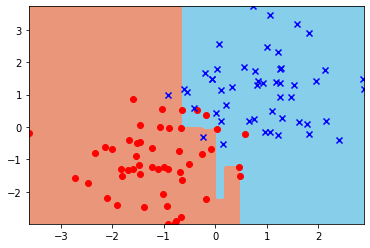

In [75]:
random.seed(42)   # on prend 42 comme graine

foret_1 = ClassifierBaggingTree(5,0.3,0.0,True)
foret_1.train((d_desc,d_label))
# Affichage de la frontière de séparation des classes
ut.plot_frontiere(d_desc,d_label,foret_1,step=100)
ut.plot2DSet(d_desc,d_label)

print("\naccuracy totale:",foret_1.accuracy(d_desc,d_label))

### Expérimentations

<font color="RED" size="+1">**[Q]**</font> Expérimenter l'algorithme précédent de la façon suivante :
- générer un dataset de train $Data$ contenant 1000 exemples ;
- générer une base de test $T$ contenant 200 exemples ;
- réaliser un apprentissage par bagging avec $Data$ et évaluer le taux de prédiction du modèle obtenu sur $T$ ;
- construire la courbe donnant le **taux d'erreur** obtenu en augmentant la taille de la forêt d'arbres de 1 à 20 arbres. 

**Remarque**: réinitialiser la graine aléatoire avant de construire une forêt.

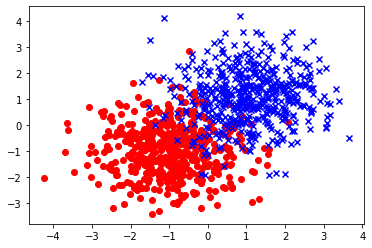

In [87]:
# On initialise la graine
np.random.seed(42)   
DATA = ut.genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                             np.array([-1,-1]),np.array([[1,0],[0,1]]), 500)
T = ut.genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                             np.array([-1,-1]),np.array([[1,0],[0,1]]), 100)
# Affichage :
ut.plot2DSet(DATA[0],DATA[1])

In [105]:
import time

In [106]:
random.seed(42)
print("Taille du train set généré : {} exemples".format(DATA[0].shape))
print("Taille du test set généré  : {} exemples".format(T[0].shape))
d_desc,d_label = DATA[0],DATA[1]
t_desc,t_label = T[0],T[1]
train, test = [], []
tic = time.time()
for b in range(20):
    foret_2 = ClassifierBaggingTree(b+1,0.75,0.0,True)
    foret_2.train(DATA)
    train.append(1-foret_2.accuracy(d_desc,d_label))
    test.append(1-foret_2.accuracy(t_desc,t_label))
print("Finished Execution", round(time.time()-tic), " seconds")

Taille du train set généré : (1000, 2) exemples
Taille du test set généré  : (200, 2) exemples
Finished Execution 183


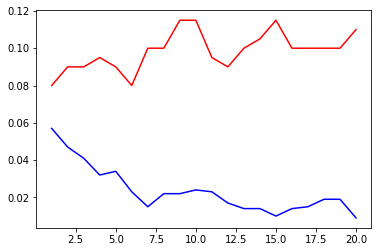

In [107]:
x_axis = [i+1 for i in range(20)]
plt.plot(x_axis, train,color = 'blue')
plt.plot(x_axis, test, color = 'red')

Taille du train set généré : (200, 2) exemples
Taille du test set généré : (1000, 2) exemples
On choisit: 75% des exemples pour construire un arbre et seuil d'entropie à 0.0
Tirage avec remise
courbe bleue: train;	courbe rouge: test


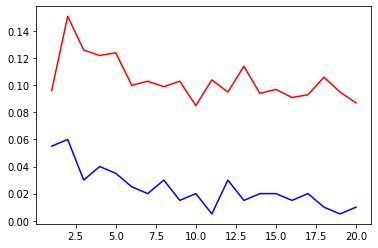

## Random forests

<font color="RED" size="+1"><b>[Q]</b></font> Ecrire et tester la classe <code>ClassifierRandomForest</code> qui implémente l'algorithme des random forests vu en cours.

Pour cela, vous devrez:
- définir une méthode <code>construit_AD_aleatoire(LS,epsilon,nb_att)</code> qui utilise $nb_att$ attributs choisis aléatoirement à chaque niveau de la construction de l'arbre
- définir une nouvelle classe <code>ArbreDecisionAleatoire</code> qui étend la classe <code>ArbreDecision</code> en surchargeant la méthode <code>train</code>. Le constructeur d'un tel arbre prendra en argument le nombre d'attributs à utiliser lors de la construction de l'arbre.

**Remarque:** pour expérimenter (selon le modèle de l'exemple précédent, il est plus intéressant d'avoir un dataset avec plus de 2 colonnes, vous pourrez donc prendre les datasets vus dans les tme précédent (iris, ou usks).

In [ ]:
class ClassifierRandomForest(cl.Classifier):
    def __init__(self, B, perc, seuil, r):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        self.B = B
        self.perc = perc
        self.r = r
        self.seuil = seuil
        
    def train(self, LabeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.treeSet = set(cl.ClassifierArbreNumerique(LabeledSet[0][1], self.seuil) for i in range(self.B))
        taille_ech = round(len(LabeledSet[0])*self.perc)
        for tree in self.treeSet:
            X, Y = echantillonLS(LabeledSet, taille_ech, self.r)
            tree.train(X,Y)
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        somme=0
        for tree in self.treeSet:
            somme += tree.predict(x)
        return +1 if somme>=0 else -1

## Expérimentation

<font color="RED" size="+1"><b>[Q]</b></font> Comparer le bagging d'arbres et les random forests sur d'autres bases d'apprentissage (réelles ou générées aléatoirement). Construire la courbe donnant le taux de prédiction pour une forêt d'arbres variant de 1 à 100 arbres (cela peut prendre du temps, tester sur un nombre réduit d'arbres dans un premier temps).

## Exercices à faire chez vous (sur papier)

Pour vous entraîner sans machine... *(exercice de l'examen 2017)*

Soit $V=\{v_{1}, v_{2},..., v_{n}\}$ un ensemble de $n$ valeurs réelles ordonnées,
  telles que $v_1 \geq v_2 \geq \ldots \geq v_{n}$.. On note $\bar{v}$ la valeur moyenne de $V$. La variance de $V$, $var(V)$ est définie par:
$var(V) = \frac{1}{n} \sum_{i=1}^{n} (v_{i} - \bar{v})^2$. 

Et soit $W=\{w_{1}, w_{2},..., w_{n}\}$ tel que,pour tout $i=1,...,n$.


<font color="RED" size="+1"><b>[Q]</b></font> Donner l'expression de $\bar{v}$ en fonction des valeurs de $V$.

<font color="RED" size="+1"><b>[Q]</b></font> Montrer que $var(aV+b) = a^2 var(V)$.

<font color="RED" size="+1"><b>[Q]</b></font> Donner l'expression de $V\cdot W$ (le produit scalaire) en fonction des coordonnées
   de $V$ et de $W$.
   
<font color="RED" size="+1"><b>[Q]</b></font> Comment doit-on définir $W$ si on souhaite que $V\cdot W = \bar{v}$ ?


<font color="RED" size="+1"><b>[Q]</b></font> Comment doit-on définir $W$ si on souhaite que
   $V\cdot W = \displaystyle\max_{i=1,...n} v_i$ ? Même question si on souhaite que
   $V\cdot W = \displaystyle\min_{i=1,...n} v_i$ ?

<font color="RED" size="+1"><b>[Q]</b></font> Soit un entier $k$ tel que $0<k\leq n$. Proposer une définition de $W$ qui, par le
   calcul du produit scalaire, permet de ne tenir compte, de façon équitable, que des $k$
   valeurs les plus élevées de $V$.



## (optionnel) Evaluation par la méthode "Out Of Bags"

<font color="RED" size="+1">**[Q]**</font> Sur les mêmes données, réaliser une évaluation par la méthode "Out Of Bags" vue en cours. Construire la courbe donnant le taux de prédiction OOB en fonction de la taille de la forêt d'arbres.

Pour cela, écrire la classe <code>ClassifierBaggingTreeOOB</code> qui étend la classe d'un classifieur bagging pour prendre en compte la spécificité de l'approche OOB.
Ainsi, à partir de $\mathcal{X}$, l'ensemble des données d'apprentissage, chaque arbre $A_i$ de la forêt est associé à 2 sous-ensembles de $\mathcal{X}$: 
- $\mathcal{X}_i$: l'échantillon bootstrap qui sert à construire l'arbre $A_i$
- $\mathcal{T}_i$: l'ensemble des exemples OOB associés à l'arbre $A_i$

Le calcul du taux de bonne classification s'effectuera comme suit:
- soit $t_i$ le taux de bonne classification de $A_i$ pour l'ensemble OOB $\mathcal{T}_i$
- le taux de global de bonne classification de la forêt d'arbres $A_1$,..., $A_B$ est donné par $\frac{1}{B}\sum_{i=1}^{B} t_i$
